# Forecast Evaluation Pipeline Using SKtime
### Examples:
- https://www.sktime.org/en/latest/examples/01_forecasting.html
- https://github.com/alan-turing-institute/sktime/blob/master/examples/01_forecasting.ipynb

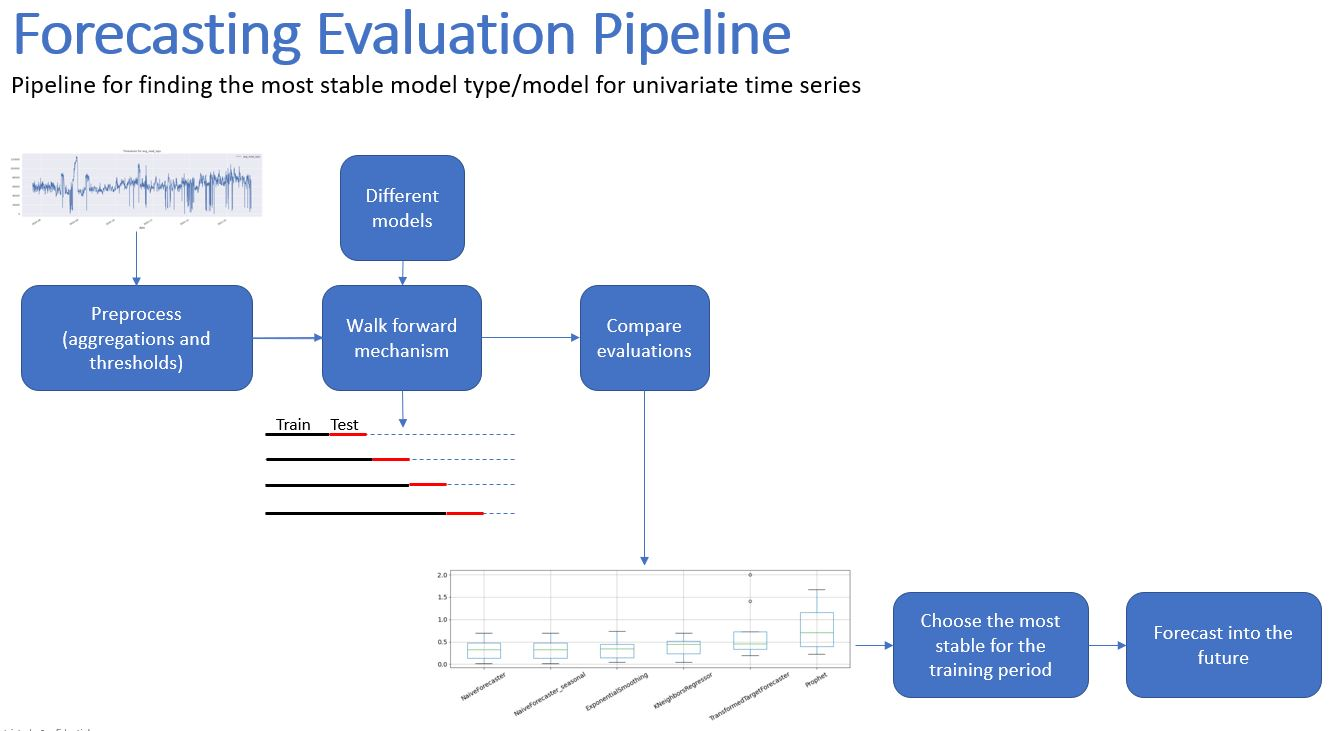

In [2]:
from IPython.display import Image
Image(filename='forecast_pipeline.jpg',width=800)

## Packages - install if needed

In [3]:
#! python -m pip install --upgrade pip

In [4]:
#! pip install pandas -U
#! pip install seaborn -U
#! pip install matplotlib -U
#! pip install statsmodels -U

In [5]:
#! pip install sktime
#! pip install tbats
#! pip install pmdarima
#! pip install ruptures
#! pip install changefinder

## Imports

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = '14'

import time

import numpy as np
import scipy as sp

import pandas as pd

In [7]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from math import sqrt

In [8]:
import forecast_eval_pipeline_using_sktime as frcstpipe

In [9]:
import importlib
importlib.reload(frcstpipe);

In [10]:
# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [11]:
from warnings import simplefilter

#from sktime.datasets import load_airline
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    #ReducedRegressionForecaster,
    RecursiveRegressionForecaster,
    TransformedTargetForecaster,
)

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
#%matplotlib inline

from sktime.forecasting.ets import AutoETS
from sktime.forecasting.bats import BATS
from sktime.forecasting.tbats import TBATS

from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.fbprophet import Prophet

# Load Data - from file

In [12]:
filename = "nasdaq_stocks.csv"
data = pd.read_csv(filename)
print(data.shape)
data.head(5)

(808, 18)


,date,FB,GOOGL,AMZN,DELL,IBM,INTC,AAPL,MSFT,CSCO,ORCL,NVDA,VMW,HPQ,AMD,TSM,TXN,QCOM
0,2016-01-04,102.22,759.44,636.99,NaN,119.2253,31.0178,99.4989,51.0656,23.9163,34.1057,31.8157,46.7698,10.5034,2.770,20.1865,49.9251,44.2740
1,2016-01-05,102.73,761.53,633.79,NaN,119.1376,30.8718,97.0055,51.2986,23.8076,34.0008,32.3268,47.3679,10.6030,2.750,20.0586,49.4014,43.4083
2,2016-01-06,102.97,759.33,632.65,NaN,118.5413,30.1874,95.1072,50.3667,23.5541,34.1725,30.9901,45.8975,10.2227,2.505,19.5012,49.0798,42.9666
3,2016-01-07,97.92,741.00,607.94,NaN,116.5155,29.0558,91.0932,48.6148,23.0107,33.4284,29.7615,45.2911,9.7519,2.275,19.2818,47.4996,40.7582
4,2016-01-08,97.33,730.91,607.05,NaN,115.4368,28.7547,91.5749,48.7639,22.4402,33.0563,29.1226,44.9422,9.5798,2.140,19.0168,46.2684,40.5241


## Infer Frequency

In [13]:
col_date = "date"
max_date = data[col_date].max()
min_date = data[col_date].min()

rng = pd.date_range(start=min_date, end=max_date, periods=data.shape[0])
infered_freq = pd.infer_freq(rng, warn=True)
print("infered_freq:", infered_freq)

if infered_freq:
    rng_with_freq = pd.date_range(start=min_date, end=max_date, freq=infered_freq)
    if rng.shape[0] != rng_with_freq.shape[0]:
        print("There may be missing data")
    else:
        print("Infered frequency matches the number of observations")

infered_freq: None


# Model Evaluation
### Methodolgy
- Choose mininmal train period
- Go over all wanted models
    - walk_forward_validation
        - go over time series in intervals similar to production
        - split to train and test, where train is for the known history and test is for the unknown
        - predict future (using some specific method) and collect predictions or errors
    - Calculate error over all test period and show results for each forecast method

### Model Dictionary
- A dictionary of models that can be used
- The forecaster string is passed to an eval function
- For simplicity the forecasters are grouped to seasonal categories
- More forecasters can easily be added or tweaked
- For model parameters, have a look in: https://www.sktime.org/en/v0.5.3/api_reference.html?highlight=prophet#sktime-forecasting-time-series-forecasting
- For tranformers, have  look in: https://www.sktime.org/en/v0.5.3/api_reference.html?highlight=prophet#sktime-transformations-time-series-transformers
- Other models (from not supported packages for example) can also be inserted using an enveloping class
    - Have a look on PolynomialTrendForecasterWithChangepoints in custom models section as an example

In [14]:
models_dict = {
    # General forecasters
    "PolynomialTrend":'PolynomialTrendForecaster(degree=1)',
    "PolynomialTrendWithChangePoints":'PolynomialTrendForecasterWithChangepoints(degree=1, modeltype="binary", number_breakpoints=5, min_period=90)',
    "NaiveForecaster": 'NaiveForecaster(strategy="last")',
    "ExponentialSmoothingBoxCox": 'ExponentialSmoothing(trend="add", seasonal=None, sp=None, use_boxcox=True)',
    "ExponentialSmoothing": 'ExponentialSmoothing(trend="add", seasonal=None, sp=None)',
    "AutoETS": 'AutoETS(auto=True, sp=1, n_jobs=-1)',
    "AutoARIMA1": 'AutoARIMA(sp=1, suppress_warnings=True)',
    "Arima010": 'ARIMA( order=(0, 1, 0), suppress_warnings=True)',
    "BATS": 'BATS(sp=1, use_trend=True, use_box_cox=False)',
    "TBATS": 'TBATS(sp=1, use_trend=True, use_box_cox=True)',
    "KNeighborsRegressor5": 'RecursiveRegressionForecaster(regressor=KNeighborsRegressor(n_neighbors=1), window_length=5)',
    "KNeighborsRegressor10": 'RecursiveRegressionForecaster(regressor=KNeighborsRegressor(n_neighbors=1), window_length=10)',
    "KNeighborsRegressor15": 'RecursiveRegressionForecaster(regressor=KNeighborsRegressor(n_neighbors=1), window_length=15)',
    "Prophet": 'Prophet(seasonality_mode="multiplicative", yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=False)',   
    "TransformedTargetForecaster": '''
        TransformedTargetForecaster(
            [
                ("deseasonalise", Deseasonalizer(model="multiplicative", sp=1)),
                ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
                (
                    "forecast",
                    RecursiveRegressionForecaster(
                        regressor=KNeighborsRegressor(n_neighbors=1), window_length=4
                    ),
                ),
            ]
        )
        ''',
    # 24 hour seasonality forecasters
    "NaiveForecaster_seasonal24": 'NaiveForecaster(strategy="last", sp=24)',
    "ExponentialSmoothingAdd24": 'ExponentialSmoothing(trend="add", seasonal="add", sp=24)',
    "ExponentialSmoothingMul24": 'ExponentialSmoothing(trend="mul", seasonal="mul", sp=24)',
    "AutoETS24": 'AutoETS(auto=True, sp=24, n_jobs=-1)',
    "AutoARIMA24": 'AutoARIMA(sp=24, suppress_warnings=True)',
    "BATS24": 'BATS(sp=24, use_trend=True, use_box_cox=False)',
    "TBATS24": 'TBATS(sp=24, use_trend=True, use_box_cox=True)',
    "KNeighborsRegressor12": 'RecursiveRegressionForecaster(regressor=KNeighborsRegressor(n_neighbors=1), window_length=12)',
    "KNeighborsRegressor24": 'RecursiveRegressionForecaster(regressor=KNeighborsRegressor(n_neighbors=1), window_length=24)',
    "KNeighborsRegressor48": 'RecursiveRegressionForecaster(regressor=KNeighborsRegressor(n_neighbors=1), window_length=48)', 
    "Prophet24": 'Prophet(seasonality_mode="multiplicative", yearly_seasonality=False,weekly_seasonality=True,daily_seasonality=True)',   
    "Ensemble24": '''
        EnsembleForecaster(
            [
                ("trend", PolynomialTrendForecaster(degree=1)),
                ("naive", NaiveForecaster(strategy="last", sp=24)),
                ("esadd", ExponentialSmoothing(trend="add", seasonal="add", sp=24)),
                ("esmul", ExponentialSmoothing(trend="mul", seasonal="mul", sp=24)),
                ("autoets", AutoETS(auto=True, sp=24, n_jobs=-1)),
            ]
        )
        ''',
    # 7 days seasonality forecasters
    "NaiveForecaster_seasonal7": 'NaiveForecaster(strategy="last", sp=7)',
    "ExponentialSmoothingAdd7": 'ExponentialSmoothing(trend="add", seasonal="add", sp=7)',
    "ExponentialSmoothingMul7": 'ExponentialSmoothing(trend="mul", seasonal="mul", sp=7)',
    "AutoETS7": 'AutoETS(auto=True, sp=7, n_jobs=-1)',
    "AutoARIMA7": 'AutoARIMA(sp=7, suppress_warnings=True)',
    "BATS7": 'BATS(sp=7, use_trend=True, use_box_cox=False)',
    "TBATS7": 'TBATS(sp=7, use_trend=True, use_box_cox=True)',
    "KNeighborsRegressor7": 'RecursiveRegressionForecaster(regressor=KNeighborsRegressor(n_neighbors=1), window_length=7)',
    "KNeighborsRegressor14": 'RecursiveRegressionForecaster(regressor=KNeighborsRegressor(n_neighbors=1), window_length=14)',
    "Prophet7": 'Prophet(seasonality_mode="multiplicative", yearly_seasonality=False,weekly_seasonality=True,)',   
    "Ensemble7": '''
        EnsembleForecaster(
            [
                ("trend", PolynomialTrendForecaster(degree=1)),
                ("naive", NaiveForecaster(strategy="last", sp=7)),
                ("esadd", ExponentialSmoothing(trend="add", seasonal="add", sp=7)),
                ("esmul", ExponentialSmoothing(trend="mul", seasonal="mul", sp=7)),
                ("autoets", AutoETS(auto=True, sp=7, n_jobs=-1)),
            ]
        )
        ''',
    # 5 days seasonality forecasters
    "NaiveForecaster_seasonal5": 'NaiveForecaster(strategy="last", sp=5)',
    "ExponentialSmoothingAdd5": 'ExponentialSmoothing(trend="add", seasonal="add", sp=5)',
    "ExponentialSmoothingMul5": 'ExponentialSmoothing(trend="mul", seasonal="mul", sp=5)',
    "AutoETS5": 'AutoETS(auto=True, sp=5, n_jobs=-1)',
    "AutoARIMA5": 'AutoARIMA(sp=5, suppress_warnings=True)',
    "BATS5": 'BATS(sp=5, use_trend=True, use_box_cox=False)',
    "TBATS5": 'TBATS(sp=5, use_trend=True, use_box_cox=True)',
    "KNeighborsRegressor5": 'RecursiveRegressionForecaster(regressor=KNeighborsRegressor(n_neighbors=1), window_length=5)',
    "KNeighborsRegressor10": 'RecursiveRegressionForecaster(regressor=KNeighborsRegressor(n_neighbors=1), window_length=10)',
    "KNeighborsRegressor20": 'RecursiveRegressionForecaster(regressor=KNeighborsRegressor(n_neighbors=1), window_length=20)',
    "Prophet5": 'Prophet(seasonality_mode="multiplicative", yearly_seasonality=False,weekly_seasonality=True,)',   
    "Ensemble5": '''
        EnsembleForecaster(
            [
                ("trend", PolynomialTrendForecaster(degree=1)),
                ("naive", NaiveForecaster(strategy="last", sp=5)),
                ("esadd", ExponentialSmoothing(trend="add", seasonal="add", sp=5)),
                ("esmul", ExponentialSmoothing(trend="mul", seasonal="mul", sp=5)),
                ("autoets", AutoETS(auto=True, sp=5, n_jobs=-1)),
            ]
        )
        ''',
    # 4 weeks seasonality forecasters
    "NaiveForecaster_seasonal4": 'NaiveForecaster(strategy="last", sp=4)',
    "ExponentialSmoothingAdd4": 'ExponentialSmoothing(trend="add", seasonal="add", sp=4)',
    "ExponentialSmoothingMul4": 'ExponentialSmoothing(trend="mul", seasonal="mul", sp=4)',
    "AutoETS4": 'AutoETS(auto=True, sp=4, n_jobs=-1)',
    "AutoARIMA4": 'AutoARIMA(sp=4, suppress_warnings=True)',
    "BATS4": 'BATS(sp=4, use_trend=True, use_box_cox=False)',
    "TBATS4": 'TBATS(sp=4, use_trend=True, use_box_cox=True)',
    "KNeighborsRegressor4": 'RecursiveRegressionForecaster(regressor=KNeighborsRegressor(n_neighbors=1), window_length=4)',
    "KNeighborsRegressor8": 'RecursiveRegressionForecaster(regressor=KNeighborsRegressor(n_neighbors=1), window_length=8)',
    "Prophet4": 'Prophet(seasonality_mode="multiplicative", yearly_seasonality=True,weekly_seasonality=False,)',   
    "Ensemble4": '''
        EnsembleForecaster(
            [
                ("trend", PolynomialTrendForecaster(degree=1)),
                ("naive", NaiveForecaster(strategy="last", sp=4)),
                ("esadd", ExponentialSmoothing(trend="add", seasonal="add", sp=4)),
                ("esmul", ExponentialSmoothing(trend="mul", seasonal="mul", sp=4)),
                ("autoets", AutoETS(auto=True, sp=4, n_jobs=-1)),
            ]
        )
        ''',

    } 

# Run Evaluation on Univariate time series

In [15]:
import importlib
importlib.reload(frcstpipe);

## Load series
- Given a csv filename, date column name and a value column name, a pandas series is returned (indexed with date transformed to datetime)

In [16]:
# Load series
col_date = "date"
col = "AMZN"
series = frcstpipe.load_series_from_file(filename, col_date, col)
series

data.shape: (808, 18)


date
2016-01-04     636.99
2016-01-05     633.79
2016-01-06     632.65
2016-01-07     607.94
2016-01-08     607.05
               ...   
2019-03-14    1686.22
2019-03-15    1712.36
2019-03-18    1742.15
2019-03-19    1761.85
2019-03-20    1797.27
Name: AMZN, Length: 808, dtype: float64

## Preprocess
- Setting the original frequency of the series
- Setting some flags (control filling gaps, removing extreme outliers)
- Choosing the amount of data to used
- setting a new frequency if needed (needs the resample_flag to be true as well)
- Not all forecaster work with non trivial freqency, for this we can set the new_frequency to be 'strip_frequency'
    - the strip_frequency will create an integers index, the original index will be used for plotting purposes

<AxesSubplot:xlabel='date'>

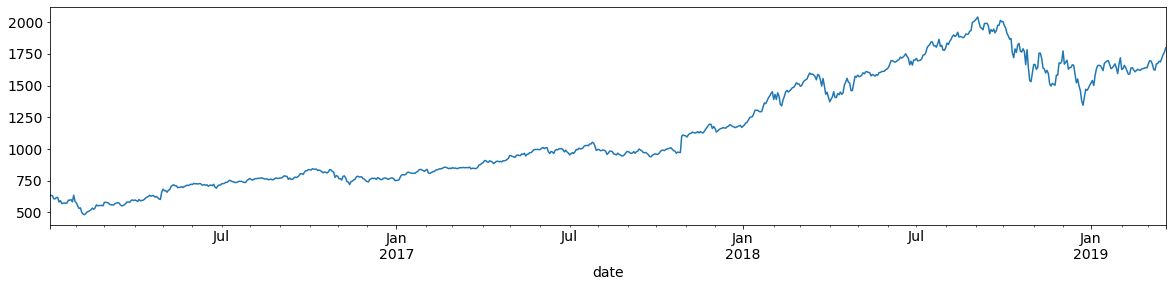

In [17]:
frequency = 'B'
fill_na_flag=True
remove_max_outliers_flag=True
percentage_data=100
resample_flag=False # False / True
new_frequency='strip_frequency' # 'D' / 'W' / 'M' / 'strip_frequency' - use strip_frequency if frequency is special
series, original_series_index = frcstpipe.preprocess_series(series, frequency, fill_na_flag, remove_max_outliers_flag, percentage_data, resample_flag, new_frequency)

if new_frequency=='strip_frequency':
    series_for_plot = frcstpipe.reindex_series(series, original_series_index)
else:
    series_for_plot = series
    
series_for_plot.plot(figsize=(20,4))

## Run Evaluation Pipeline
- Model lists are used to choose the actual models that go into the pipeline. Comment out those that are not neccessary
    The actual forecatsters will be taken from the model dictionary
- The models that will be chosen will be the models_general + the list that depends on the freqency
- Setting time variables (start_train_size, max_train_size, forecast_horizon, step_size) will be used in the original frequency
    - They will be recalculated if needed
    - For new freaquencies not used before, we might need to add tranformation details into the dictionary im calc_periods_for_new_frequency function
    - If the max_train will be smaller than start_train it will exapand, the training period will always exapnd
- Setting the loss metric
- Notice that ARIMA seasonal period requires more than 3 times the periods for training

In [18]:
#list(models_dict.keys())
models_general = ['PolynomialTrend',
                  'PolynomialTrendWithChangePoints',
                  'NaiveForecaster',
                  #'ExponentialSmoothingBoxCox',
                  #'ExponentialSmoothing',
                  'AutoETS',
                  #'AutoARIMA1',
                  'Arima010',
                  #'BATS',
                  #'TBATS',
                  'KNeighborsRegressor5',
                  'KNeighborsRegressor10',
                  'KNeighborsRegressor15',
                  #'Prophet',
                  'TransformedTargetForecaster'
                 ]
models_hour = ['NaiveForecaster_seasonal24',
                 'ExponentialSmoothingAdd24',
                 'ExponentialSmoothingMul24',
                 'AutoETS24',
                 #'AutoARIMA24',
                 #'BATS24',
                 #'TBATS24',
                 #'KNeighborsRegressor12',
                 'KNeighborsRegressor24',
                 #'KNeighborsRegressor48',
                 #'Prophet24',
                 'Ensemble24'
              ]
models_day = ['NaiveForecaster_seasonal7',
                 #'ExponentialSmoothingAdd7',
                 #'ExponentialSmoothingMul7',
                 'AutoETS7',
                 #'AutoARIMA7',
                 #'BATS7',
                 #'TBATS7',
                 'KNeighborsRegressor7',
                 #'KNeighborsRegressor14',
                 #'Prophet7',
                 #'Ensemble7'
              ] 
models_bday = ['NaiveForecaster_seasonal5',
                 #'ExponentialSmoothingAdd5',
                 #'ExponentialSmoothingMul5',
                 'AutoETS5',
                 #'AutoARIMA5',
                 #'BATS5',
                 #'TBATS5',
                 #'KNeighborsRegressor5',
                 #'KNeighborsRegressor10',
                 'KNeighborsRegressor20',
                 #'Prophet5',
                 #'Ensemble5'
              ]
models_week = ['NaiveForecaster_seasonal4',
                 'ExponentialSmoothingAdd4',
                 'ExponentialSmoothingMul4',
                 'AutoETS4',
                 #'AutoARIMA4',
                 #'BATS4',
                 #'TBATS4',
                 'KNeighborsRegressor4',
                 #'KNeighborsRegressor8',
                 #'Prophet4',
                 'Ensemble4']

In [19]:
freq_to_model = {'H':models_hour, 'D':models_day, 'W': models_week, 'M': [], 'strip_frequency': models_bday}

In [20]:
models_to_use_list = models_general.copy()
models_to_use_list.extend(freq_to_model[new_frequency])
print("models_to_use_list:", models_to_use_list)

loss_metric="smape"

# *** time points entered in the original freqency ***
start_train_size = 5*20
max_train_size = 5*20 # if the max_train will be < start_train it will exapand
forecast_horizon = 5*4
step_size = 5*4

result_df, models_error_series = frcstpipe.eval_pipeline(series, models_dict, models_to_use_list, loss_metric, 
                                    start_train_size, max_train_size, forecast_horizon, step_size, frequency, new_frequency)

models_to_use_list: ['PolynomialTrend', 'PolynomialTrendWithChangePoints', 'NaiveForecaster', 'AutoETS', 'Arima010', 'KNeighborsRegressor5', 'KNeighborsRegressor10', 'KNeighborsRegressor15', 'TransformedTargetForecaster', 'NaiveForecaster_seasonal5', 'AutoETS5', 'KNeighborsRegressor20']
series size: 838
number_of_steps: 35
PolynomialTrend 0.041421030894036974
[exp msg] elapsed time for process: 00:00:00
number_of_steps: 35
PolynomialTrendWithChangePoints 0.03989741989230719
[exp msg] elapsed time for process: 00:00:00
number_of_steps: 35
NaiveForecaster 0.030770991848644125
[exp msg] elapsed time for process: 00:00:00
number_of_steps: 35
AutoETS 0.027558877294768185
[exp msg] elapsed time for process: 00:00:06
number_of_steps: 35
Arima010 0.021842378313741046
[exp msg] elapsed time for process: 00:00:00
number_of_steps: 35
KNeighborsRegressor5 0.032509382430668005
[exp msg] elapsed time for process: 00:00:01
number_of_steps: 35
KNeighborsRegressor10 0.03166870052776792
[exp msg] elapse

## Show results
- Box-plots of the populations of loss of each experiment, for each model
- Also shwon as a line plot

<AxesSubplot:>

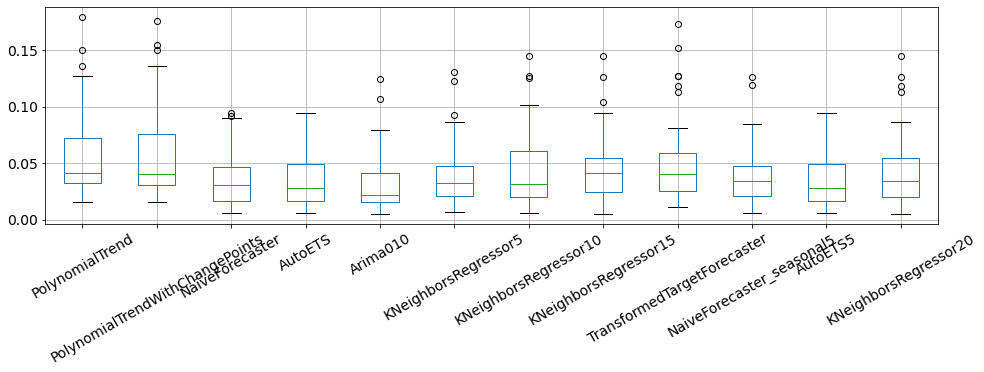

In [21]:
result_df.boxplot(rot=30, figsize=(16,4))

<AxesSubplot:>

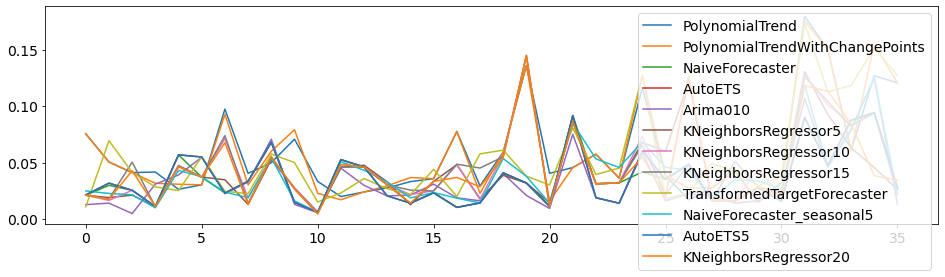

In [22]:
result_df.plot(figsize=(16,4))

### Top Model
- Top model is being chosen:
    - Taking top k models using theie median loss
    - Then choosing the one that has the loweset value on a chosen percentile (to diminish large errors)
    - Can be changed in get_top_model function

In [23]:
frcstpipe.get_top_model(result_df)

'Arima010'

# Use top model
- Re-calculating time variables if frequency was changed
- Examples for known future, unknown future w/o prediction interval
    - The "accuracy" of prediction interval can be set in get_interval_error function
    - Use the table in https://otexts.com/fpp2/prediction-intervals.html

In [24]:
# Re-calculating time variables if frequency was changed
if new_frequency != frequency and new_frequency != 'strip_frequency':
    start_train_size = frcstpipe.calc_periods_for_new_frequency(start_train_size, frequency, new_frequency)
    max_train_size = frcstpipe.calc_periods_for_new_frequency(max_train_size, frequency, new_frequency)
    forecast_horizon = frcstpipe.calc_periods_for_new_frequency(forecast_horizon, frequency, new_frequency)
    step_size = frcstpipe.calc_periods_for_new_frequency(step_size, frequency, new_frequency)

## Known future

In [25]:
# Split to train and test according to the last step
test_size = forecast_horizon

series_train, series_test = temporal_train_test_split(series, test_size=test_size)

if max_train_size >= start_train_size and max_train_size < series_train.shape[0]:
    series_train = series_train.iloc[-max_train_size:]

# Generating Forecast horizon
fh = ForecastingHorizon(series_test.index, is_relative=False)

loss_metric = "smape"
return_prediction= True
model_to_use = frcstpipe.get_top_model(result_df)
print("model chosen:", model_to_use)
current_smape_loss, series_pred = frcstpipe.forcaster_fit_and_predict(model_to_use, series_train, series_test, fh, models_dict, loss_metric, return_prediction)
print("current_smape_loss:", current_smape_loss)

model chosen: Arima010
current_smape_loss: 0.051031327277075045


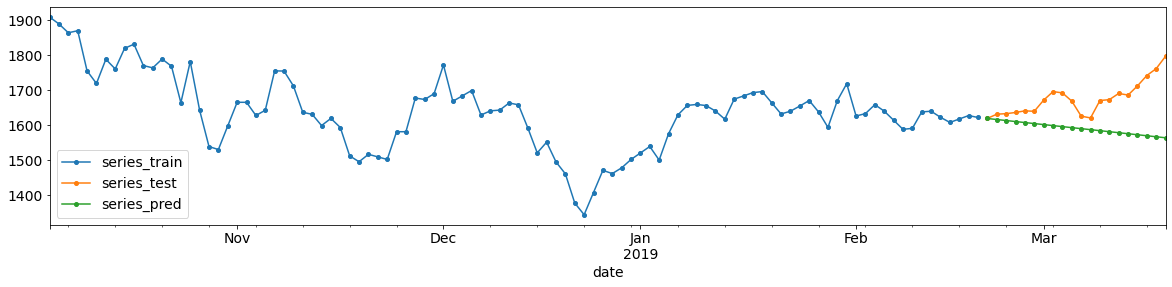

In [26]:
if new_frequency=='strip_frequency':
    frcstpipe.plot_series_train_test_pred(series_train, series_test, series_pred, reindex_flag=True, original_series_index=original_series_index)
else:
    frcstpipe.plot_series_train_test_pred(series_train, series_test, series_pred)

## Unknown future

In [27]:
series_for_fit = series
if max_train_size >= start_train_size and max_train_size < series.shape[0]:
    series_for_fit = series.iloc[-max_train_size:]
    
# Generating Forecast horizon
fh = frcstpipe.get_horizon_object_for_unknown_future(series, forecast_horizon, new_frequency)

model_to_use = frcstpipe.get_top_model(result_df)
print("model chosen:", model_to_use)
series_pred = frcstpipe.forcaster_fit_and_predict_future(model_to_use, series_for_fit, fh, models_dict)

model chosen: Arima010


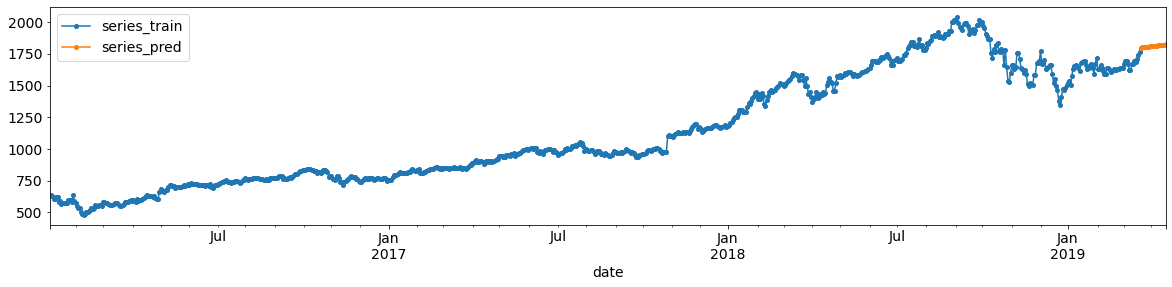

In [28]:
if new_frequency=='strip_frequency':
    frcstpipe.plot_series_train_pred(series, series_pred, reindex_flag=True, original_series_index=original_series_index, frequency=frequency)
else:
    frcstpipe.plot_series_train_pred(series,series_pred)

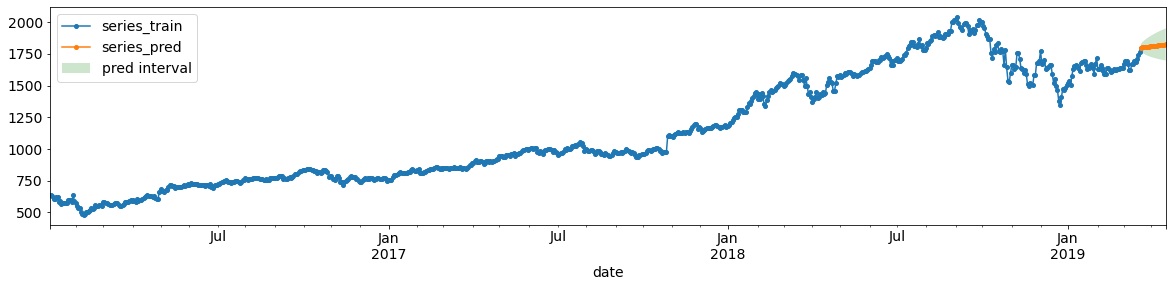

In [29]:
prediction_interval_flag=True

if new_frequency=='strip_frequency':
    series_for_fit_for_plot = frcstpipe.reindex_series(series, original_series_index)
    future_index = pd.date_range(start=series_for_fit_for_plot.index[-1], periods=series_pred.shape[0], freq=frequency)
    series_pred_for_plot = frcstpipe.reindex_series(series_pred, future_index)
    
    pred_int_df = frcstpipe.get_prediction_interval_dataframe_from_experiment(models_error_series, model_to_use, series_pred_for_plot)
    frcstpipe.plot_series_train_pred(series, series_pred, reindex_flag=True, prediction_interval_flag=True, pred_int_df=pred_int_df, 
                                     original_series_index=original_series_index, frequency=frequency)
else:
    pred_int_df = frcstpipe.get_prediction_interval_dataframe_from_experiment(models_error_series, model_to_use, series_pred)
    frcstpipe.plot_series_train_pred(series, series_pred, prediction_interval_flag=True, pred_int_df=pred_int_df)

# Example of experimenting with one forecatser for model testing

In [30]:
# Split to train and test according to the last step
test_size = forecast_horizon

series_train, series_test = temporal_train_test_split(series, test_size=test_size)

if max_train_size >= start_train_size and max_train_size < series_train.shape[0]:
    series_train = series_train.iloc[-max_train_size:]

# Generating Forecast horizon
fh = ForecastingHorizon(series_test.index, is_relative=False)

loss_metric = "smape"

0.03227636272294064


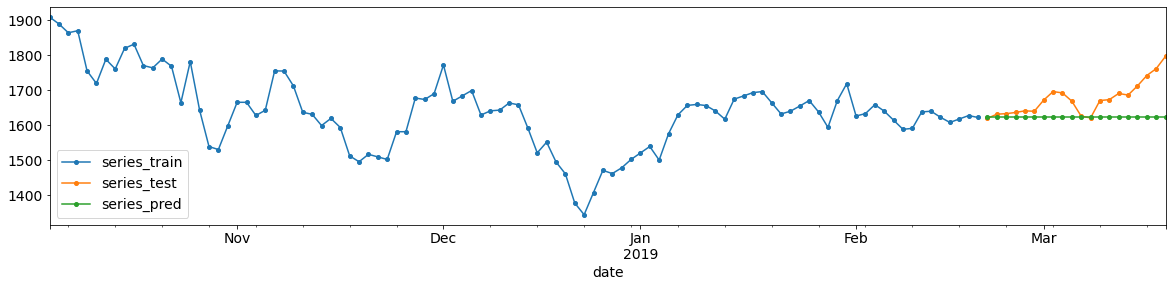

In [34]:
# Using NaiveForecaster
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(series_train)
series_pred = forecaster.predict(fh)

print(smape_loss(series_pred, series_test))
if new_frequency=='strip_frequency':
    frcstpipe.plot_series_train_test_pred(series_train, series_test, series_pred, reindex_flag=True, original_series_index=original_series_index)
else:
    frcstpipe.plot_series_train_test_pred(series_train, series_test, series_pred)

0.03227636272294064


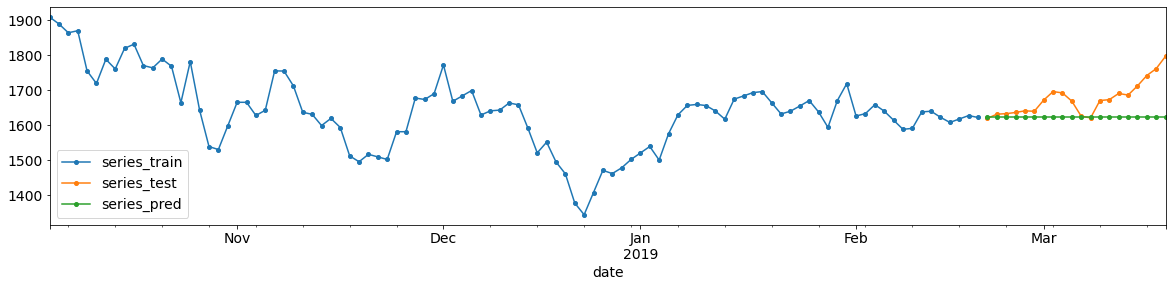

In [33]:
# Using AutoARIMA
forecaster = AutoARIMA(sp=5, suppress_warnings=True)
forecaster.fit(series_train)
series_pred = forecaster.predict(fh)

print(smape_loss(series_pred, series_test))
if new_frequency=='strip_frequency':
    frcstpipe.plot_series_train_test_pred(series_train, series_test, series_pred, reindex_flag=True, original_series_index=original_series_index)
else:
    frcstpipe.plot_series_train_test_pred(series_train, series_test, series_pred)